In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import time
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from collections import defaultdict
from typing import List
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR
from torch.utils.data import TensorDataset


In [2]:
class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.relative_importance = relative_importance

    def forward(self, output, target):
        losses = torch.stack([self.criterion(output_i, target) for output_i in output])
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.as_tensor(self.relative_importance, device=losses.device).clone().detach()        
        weighted_losses = rel_importance * losses
        return weighted_losses.mean()

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=10, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        if self.efficient:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, **kwargs)
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)
        return nesting_logits

class FixedFeatureClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super(FixedFeatureClassifier, self).__init__()
        self.classifier = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.classifier(x)


In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


In [4]:
class ResNet9(nn.Module):
    def __init__(self, nesting_list, num_classes=10):
        super(ResNet9, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        
        self.linear = MRL_Linear_Layer(nesting_list, num_classes=num_classes, efficient=False)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def get_features(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        return out


In [5]:
class ResNet9Fixed(nn.Module):
    def __init__(self, embedding_size, num_classes=10):
        super(ResNet9Fixed, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        
        self.embedding_adjust = nn.Linear(256, embedding_size)
        self.linear = nn.Linear(embedding_size, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.embedding_adjust(out)
        out = self.linear(out)
        return out
    
    def get_features(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.embedding_adjust(out)
        return out

In [6]:
def prepare_data():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_size = int(0.9 * len(train_set))
    val_size = len(train_set) - train_size
    train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)
    val_loader = DataLoader(val_set, batch_size=100, shuffle=False, num_workers=1)
    test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=1)
    
    return train_loader, val_loader, test_loader


In [7]:
def train_and_test_fixed_models(nesting_list, train_loader, val_loader, test_loader, device, epochs=10):
    models = {}
    results = {}
    
    for size in nesting_list:
        print(f"\n{'='*50}")
        print(f"Training ResNet9 with fixed embedding size: {size}")
        print(f"{'='*50}")
        
        model = ResNet9Fixed(size, num_classes=10).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
        
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        
        with tqdm(range(epochs), desc=f'Training size {size}', file=sys.stdout, colour='green', ncols=120) as pbar:
            for epoch in pbar:
                model.train()
                train_loss = 0
                correct = 0
                total = 0
                
                for batch_idx, (inputs, targets) in enumerate(train_loader):
                    inputs, targets = inputs.to(device), targets.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()
                
                train_acc = 100. * correct / total
                
                # Validation
                model.eval()
                val_loss = 0
                val_correct = 0
                val_total = 0
                
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        
                        val_loss += loss.item()
                        _, predicted = outputs.max(1)
                        val_total += targets.size(0)
                        val_correct += predicted.eq(targets).sum().item()
                
                val_acc = 100. * val_correct / val_total
                scheduler.step()
                
                train_losses.append(train_loss/len(train_loader))
                train_accs.append(train_acc)
                val_losses.append(val_loss/len(val_loader))
                val_accs.append(val_acc)
                
                pbar.set_postfix({
                    'Train Acc': f'{train_acc:.2f}%',
                    'Val Acc': f'{val_acc:.2f}%',
                    'LR': f'{optimizer.param_groups[0]["lr"]:.5f}'
                })
        
        # Testing
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()
        
        test_acc = 100. * test_correct / test_total
        results[size] = test_acc
        
        # Plot training curves for this model
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'Loss (Size {size})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.title(f'Accuracy (Size {size})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        models[size] = model
    
    # Print summary table
    print("\nFixed Size Models Test Results:")
    print("┌──────────┬────────────┐")
    print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │")
    print("├──────────┼────────────┤")
    
    for size in nesting_list:
        print(f"│ {size:^8} │ {results[size]:>9.2f}% │")
    
    avg_acc = sum(results.values()) / len(results)
    print("├──────────┼────────────┤")
    print(f"│ {'Average':^8} │ {avg_acc:>9.2f}% │")
    print("└──────────┴────────────┘")
    
    return models, results

In [8]:
def train(model, criterion, optimizer, train_loader, epoch, device):
    model.train()
    train_loss = 0
    correct = defaultdict(int)
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        for i, n in enumerate(model.linear.nesting_list):
            _, predicted = outputs[i].max(1)
            correct[n] += predicted.eq(targets).sum().item()
            
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total += targets.size(0)
    
    avg_acc = 100. * sum(correct.values()) / (total * len(model.linear.nesting_list))
        
    return train_loss/len(train_loader), avg_acc


In [9]:
def validate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0
    correct = defaultdict(int)
    total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            for i, n in enumerate(model.linear.nesting_list):
                _, predicted = outputs[i].max(1)
                correct[n] += predicted.eq(targets).sum().item()
                
            val_loss += loss.item()
            total += targets.size(0)
    
    avg_acc = 100. * sum(correct.values()) / (total * len(model.linear.nesting_list))
        
    return val_loss/len(val_loader), avg_acc


In [10]:
def test(model, test_loader, device, nesting_list=None):
    model.eval()
    test_loss = 0
    correct_top1 = defaultdict(int)
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs[0], targets)
            test_loss += loss.item()

            for i, n in enumerate(nesting_list):
                _, predicted = outputs[i].max(1)
                correct_top1[n] += predicted.eq(targets).sum().item()
            
            total += targets.size(0)

    avg_top1 = sum(100. * correct_top1[n] / total for n in nesting_list) / len(nesting_list)

    print("\n┌──────────┬────────────┐")
    print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │")
    print("├──────────┼────────────┤")

    for n in nesting_list:
        top1 = 100. * correct_top1[n] / total
        print(f"│ {n:^8} │ {top1:>9.2f}% │")

    print("├──────────┼────────────┤")
    print(f"│ {'Average':^8} │ {avg_top1:>9.2f}% │")
    print("└──────────┴────────────┘")
    
    return avg_top1, correct_top1


In [11]:
def train_classifiers(classifiers, optimizers, embedding_loader, device, nesting_list, epoch):
    criterion = nn.CrossEntropyLoss()
    train_losses = defaultdict(float)
    train_correct = defaultdict(int)
    train_total = 0

    for size in nesting_list:
        classifiers[size].train()

    for batch_features, batch_targets in embedding_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

        for size in nesting_list:
            optimizers[size].zero_grad()
            current_features = batch_features[:, :size].detach() 
                #batch_features[:, :size].clone().detach().requires_grad_(True)
            outputs = classifiers[size](current_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizers[size].step()

            train_losses[size] += loss.item()
            _, predicted = outputs.max(1)
            train_correct[size] += predicted.eq(batch_targets).sum().item()

        train_total += batch_targets.size(0)

    train_stats = {}
    for size in nesting_list:
        train_stats[size] = {
            'loss': train_losses[size] / len(embedding_loader),
            'acc': 100. * train_correct[size] / train_total
        }

    return train_stats

In [12]:
def validate_classifiers(classifiers, embedding_loader, device, nesting_list):
    val_stats = {}
    for size in nesting_list:
        classifiers[size].eval()

    with torch.no_grad():
        for batch_features, batch_targets in embedding_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

            for size in nesting_list:
                current_features = batch_features[:, :size]
                outputs = classifiers[size](current_features)
                _, predicted = outputs.max(1)

                if size not in val_stats:
                    val_stats[size] = {'correct': 0, 'total': 0}

                val_stats[size]['correct'] += predicted.eq(batch_targets).sum().item()

            current_batch_total = batch_targets.size(0)
            for size in nesting_list:
                 if size in val_stats:
                     val_stats[size]['total'] += current_batch_total

    for size in val_stats:
        if val_stats[size]['total'] > 0:
             val_stats[size]['acc'] = 100. * val_stats[size]['correct'] / val_stats[size]['total']
        else:
             val_stats[size]['acc'] = 0.0

    return val_stats

In [13]:
def test_classifiers(classifiers, embedding_loader, device, nesting_list):
    test_stats = {}
    for size in nesting_list:
        classifiers[size].eval()

    with torch.no_grad():
        overall_total = 0
        for batch_features, batch_targets in embedding_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            current_batch_total = batch_targets.size(0)
            overall_total += current_batch_total

            for size in nesting_list:
                current_features = batch_features[:, :size]
                outputs = classifiers[size](current_features)
                _, predicted = outputs.max(1)

                if size not in test_stats:
                    test_stats[size] = {'correct_top1': 0}

                test_stats[size]['correct_top1'] += predicted.eq(batch_targets).sum().item()

    print("\nFixed Feature Classifiers Test Results (on pre-computed embeddings):")
    print("\n┌──────────┬────────────┐")
    print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │")
    print("├──────────┼────────────┤")

    for size in nesting_list:
        top1 = 100. * test_stats[size]['correct_top1'] / overall_total
        test_stats[size]['total'] = overall_total
        print(f"│ {size:^8} │ {top1:>9.2f}% │")

    print("└──────────┴────────────┘")

    return test_stats

In [14]:
def plot_mrl_accuracy(mrl_correct_top1, test_loader, config):
    plt.figure(figsize=(10, 6))
    mrl_sizes = sorted(mrl_correct_top1.keys())
    mrl_accs = [100. * mrl_correct_top1[size] / len(test_loader.dataset) for size in mrl_sizes]
    
    plt.plot(mrl_sizes, mrl_accs, 'o-', color='blue', linewidth=2, markersize=8, label='MRL')
    plt.title('MRL Model Accuracy vs Feature Size')
    plt.xlabel('Feature Size')
    plt.ylabel('Top-1 Accuracy (%)')
    
    if config['log_scale']:
        plt.xscale('log')
        plt.xticks(config['nesting_list'], labels=[str(x) for x in config['nesting_list']])
    else:
        plt.xticks(config['nesting_list'])
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    for size, acc in zip(mrl_sizes, mrl_accs):
        plt.annotate(f'{acc:.1f}%', (size, acc), textcoords="offset points", xytext=(0,5), ha='center')
    
    plt.tight_layout()
    plt.show()


In [15]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2) 
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [16]:
def plot_classifier_training(nesting_list, train_loss_history, train_acc_history, val_acc_history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    for size in nesting_list:
        plt.plot(train_loss_history[size], label=f'Size {size}')
    plt.title('Training Loss per Classifier')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for size in nesting_list:
        plt.plot(train_acc_history[size], label=f'Size {size} (Train)')
        plt.plot(val_acc_history[size], '--', label=f'Size {size} (Val)')
    plt.title('Accuracy per Classifier')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [17]:
def plot_comparison(mrl_correct_top1, test_stats, test_loader, config):
    plt.figure(figsize=(10, 6))
    
    mrl_sizes = sorted(mrl_correct_top1.keys())
    mrl_accs = [100. * mrl_correct_top1[size] / len(test_loader.dataset) for size in mrl_sizes]
    
    fixed_sizes = sorted(test_stats.keys())
    fixed_accs = [test_stats[size]['correct_top1'] / test_stats[size]['total'] * 100 for size in fixed_sizes]
    
    plt.plot(mrl_sizes, mrl_accs, 'o-', label='MRL', linewidth=2)
    plt.plot(fixed_sizes, fixed_accs, 's-', label='Fixed Feature Classifiers', linewidth=2)
    
    plt.title('Comparison of MRL vs Fixed Feature Classifiers')
    plt.xlabel('Layer Size')
    plt.ylabel('Top-1 Accuracy (%)')
    
    if config['log_scale']:
        plt.xscale('log')
        plt.xticks(config['nesting_list'], labels=[str(x) for x in config['nesting_list']])
    else:
        plt.xticks(config['nesting_list'])
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [18]:
def extract_features(loader, model, device):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for inputs, targets in tqdm(loader, file=sys.stdout, colour='blue', ncols=120):
            inputs = inputs.to(device)
            features = model.get_features(inputs)
            features_list.append(features.cpu())
            labels_list.append(targets.cpu())
    return torch.cat(features_list), torch.cat(labels_list)

In [19]:
def plot_final_comparison(fixed_models_results, mrl_classifiers_results, config):
    plt.figure(figsize=(10, 6))
    
    sizes = sorted(config['nesting_list'])
    
    fixed_model_accs = [fixed_models_results[size] for size in sizes]
    
    mrl_classifiers_accs = [100. * mrl_classifiers_results[size]['correct_top1'] / 
                          mrl_classifiers_results[size]['total'] for size in sizes]
    
    plt.plot(sizes, fixed_model_accs, 'o-', label='Standalone ResNet-9', linewidth=2)
    plt.plot(sizes, mrl_classifiers_accs, 's-', label='Classifiers on MRL embeddings', linewidth=2)
    
    plt.title('Comparison: Standalone Models vs Classifiers on MRL Embeddings')
    plt.xlabel('Embedding Size')
    plt.ylabel('Top-1 Accuracy (%)')
    
    if config['log_scale']:
        plt.xscale('log')
        plt.xticks(config['nesting_list'], labels=[str(x) for x in config['nesting_list']])
    else:
        plt.xticks(config['nesting_list'])
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = {
    'nesting_list': [2, 4, 8, 16, 32, 64, 128, 256],
    'relative_importance': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    'log_scale': True,
    'epochs': 100,
    'classifier_epochs': 100
}
assert len(config['nesting_list']) == len(config['relative_importance']), \
"Длины nesting_list и relative_importance должны совпадать"

train_loader, val_loader, test_loader = prepare_data()


Files already downloaded and verified
Files already downloaded and verified



Training ResNet9 with fixed embedding size: 2
Training size 2: 100%|██████████████████| 100/100 [30:33<00:00, 18.34s/it, Train Acc=99.88%, Val Acc=92.08%, LR=0.00000]


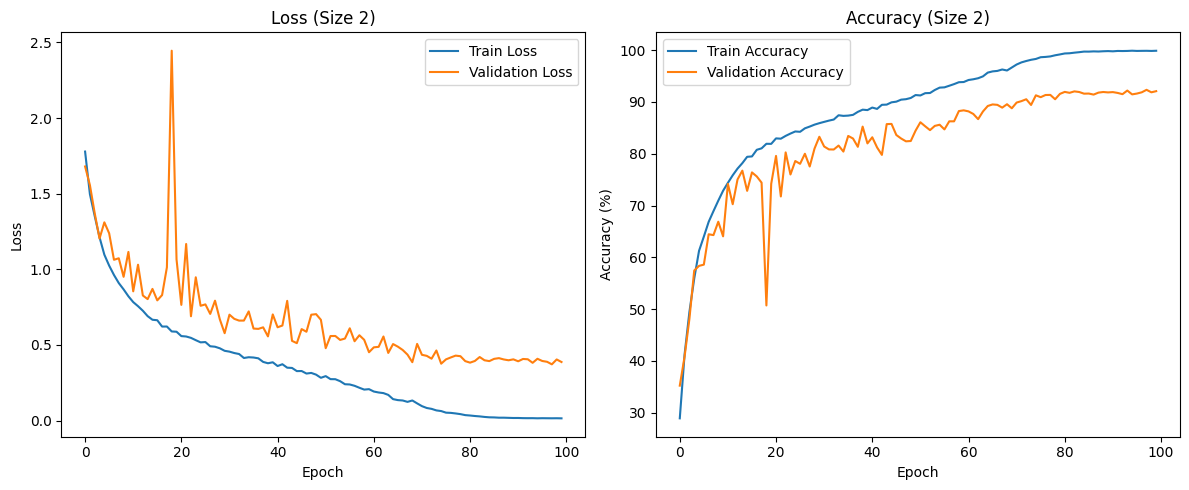


Training ResNet9 with fixed embedding size: 4
Training size 4: 100%|██████████████████| 100/100 [30:34<00:00, 18.34s/it, Train Acc=99.99%, Val Acc=93.60%, LR=0.00000]


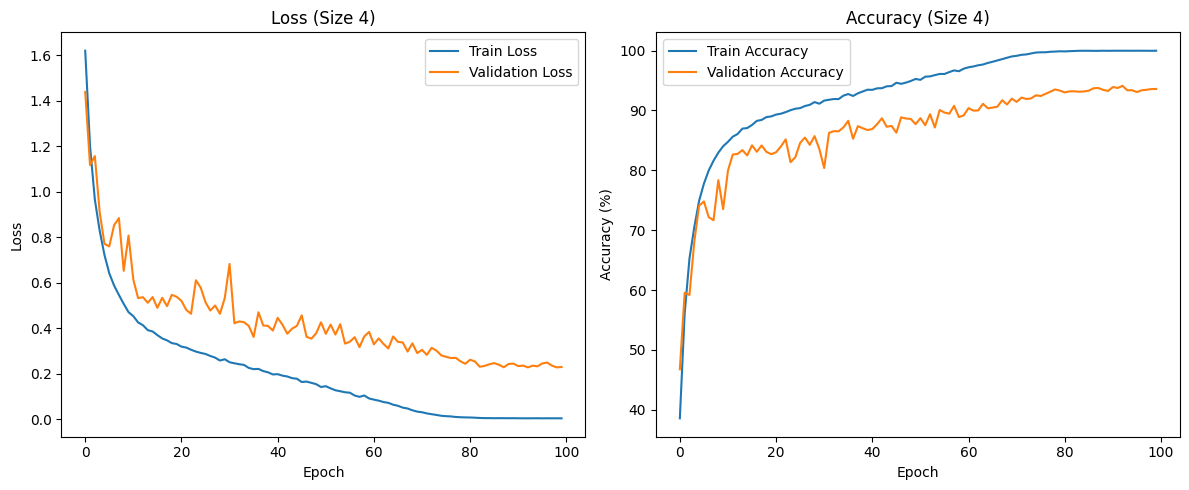


Training ResNet9 with fixed embedding size: 8
Training size 8: 100%|█████████████████| 100/100 [30:36<00:00, 18.36s/it, Train Acc=100.00%, Val Acc=94.00%, LR=0.00000]


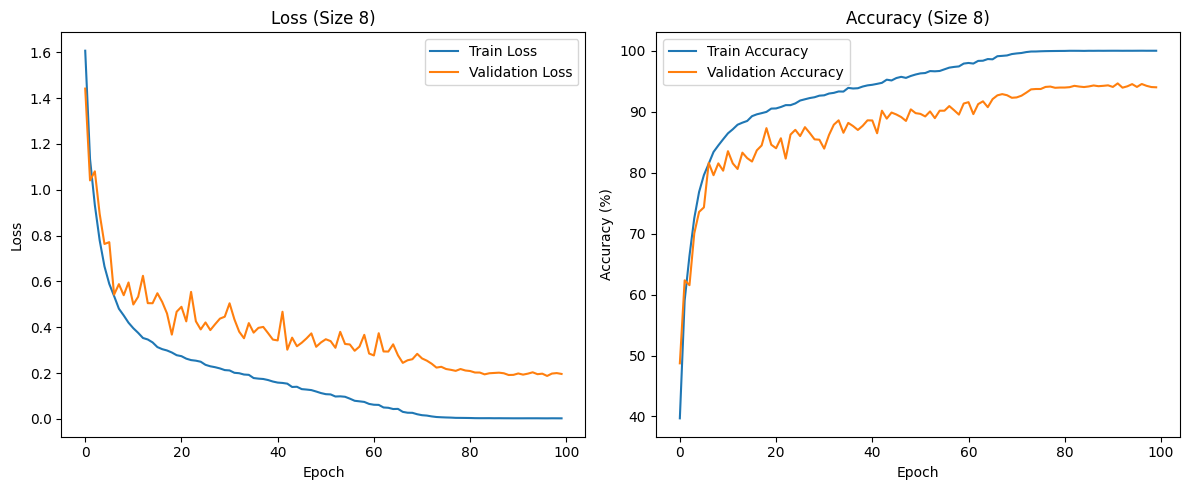


Training ResNet9 with fixed embedding size: 16
Training size 16: 100%|█████████████████| 100/100 [30:38<00:00, 18.39s/it, Train Acc=99.99%, Val Acc=94.14%, LR=0.00000]


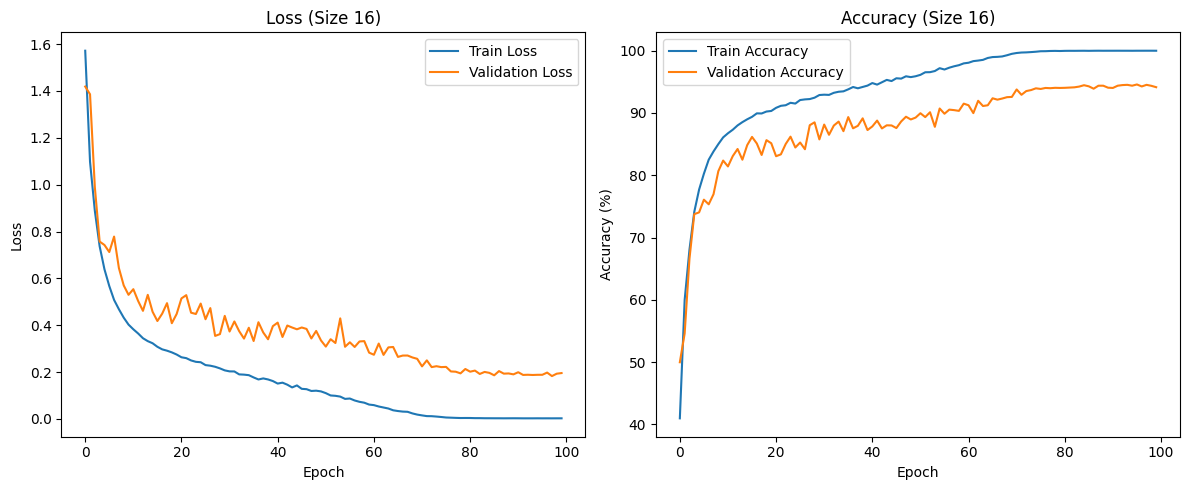


Training ResNet9 with fixed embedding size: 32
Training size 32: 100%|████████████████| 100/100 [30:47<00:00, 18.48s/it, Train Acc=100.00%, Val Acc=94.28%, LR=0.00000]


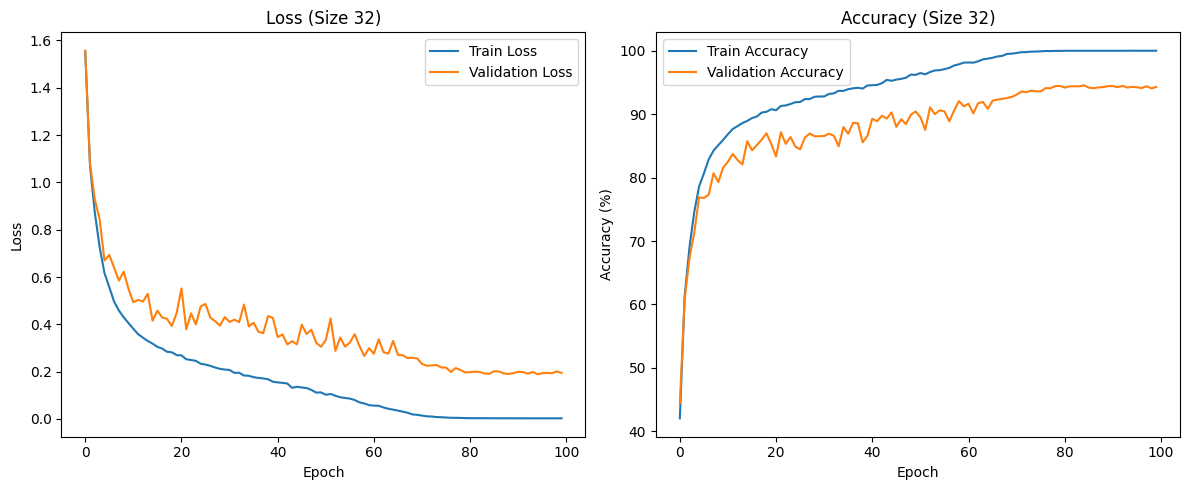


Training ResNet9 with fixed embedding size: 64
Training size 64: 100%|████████████████| 100/100 [30:46<00:00, 18.46s/it, Train Acc=100.00%, Val Acc=94.26%, LR=0.00000]


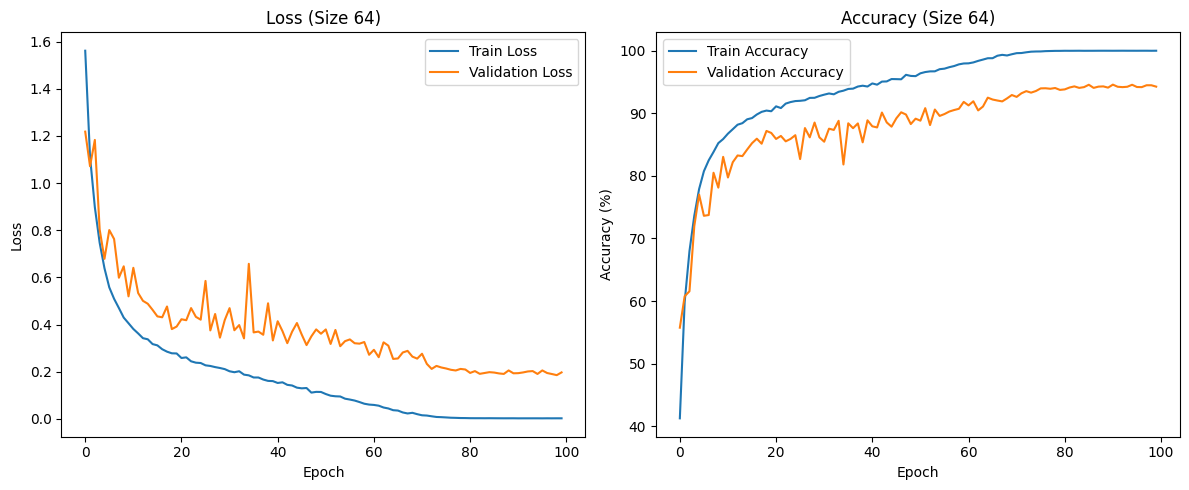


Training ResNet9 with fixed embedding size: 128
Training size 128: 100%|████████████████| 100/100 [30:42<00:00, 18.43s/it, Train Acc=99.99%, Val Acc=94.50%, LR=0.00000]


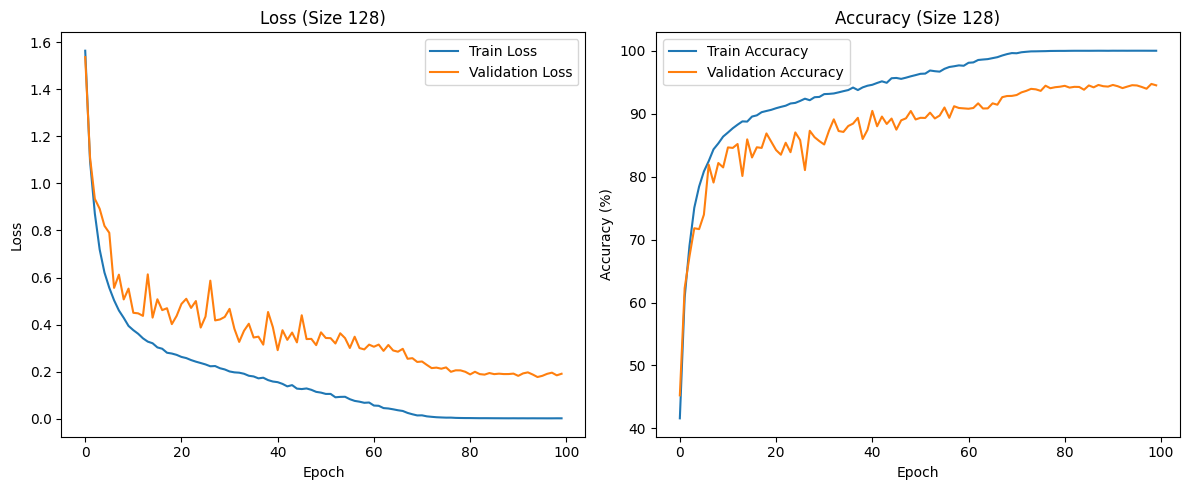


Training ResNet9 with fixed embedding size: 256
Training size 256: 100%|████████████████| 100/100 [30:39<00:00, 18.39s/it, Train Acc=99.99%, Val Acc=94.44%, LR=0.00000]


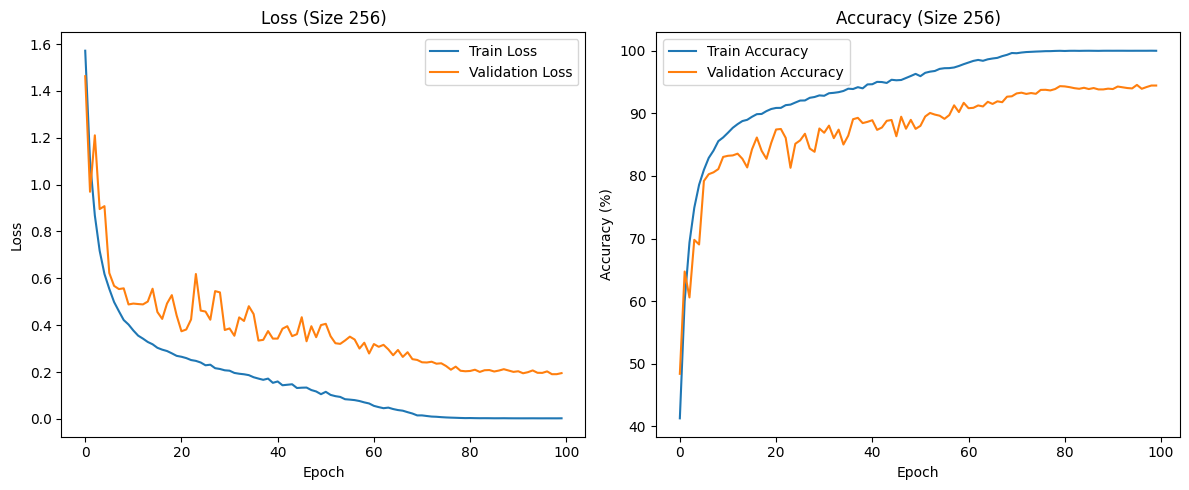


Fixed Size Models Test Results:
┌──────────┬────────────┐
│   Size   │ Top-1 Acc  │
├──────────┼────────────┤
│    2     │     92.35% │
│    4     │     93.40% │
│    8     │     94.26% │
│    16    │     94.47% │
│    32    │     94.08% │
│    64    │     94.29% │
│   128    │     94.11% │
│   256    │     94.23% │
├──────────┼────────────┤
│ Average  │     93.90% │
└──────────┴────────────┘


In [21]:
fixed_models, fixed_results = train_and_test_fixed_models(
    config['nesting_list'], 
    train_loader, 
    val_loader, 
    test_loader, 
    device, 
    epochs=config['epochs']
)

In [22]:
print(f"\n{'='*50}")
print("Starting MRL training")
print(f"{'='*50}")

model = ResNet9(config['nesting_list'], num_classes=10)
relative_importance_tensor = torch.tensor(config['relative_importance'], device=device)
criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)

model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'])

train_losses = []
train_accs = []
val_losses = []
val_accs = []

with tqdm(range(config['epochs']), desc='Training MRL model', file=sys.stdout, colour='green', ncols=120) as pbar:
    for epoch in pbar:
        train_loss, train_acc = train(model, criterion, optimizer, train_loader, epoch, device)
        val_loss, val_acc = validate(model, criterion, val_loader, device)
        scheduler.step()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        pbar.set_postfix({
            'Train Acc': f'{train_acc:.2f}%',
            'Val Acc': f'{val_acc:.2f}%',
            'LR': f'{optimizer.param_groups[0]["lr"]:.5f}'
        })



Starting MRL training
Training MRL model: 100%|███████████████| 100/100 [32:10<00:00, 19.31s/it, Train Acc=99.96%, Val Acc=93.71%, LR=0.00000]



MRL Model Test Results:

┌──────────┬────────────┐
│   Size   │ Top-1 Acc  │
├──────────┼────────────┤
│    2     │     91.85% │
│    4     │     93.43% │
│    8     │     94.33% │
│    16    │     94.37% │
│    32    │     94.39% │
│    64    │     94.39% │
│   128    │     94.38% │
│   256    │     94.38% │
├──────────┼────────────┤
│ Average  │     93.94% │
└──────────┴────────────┘


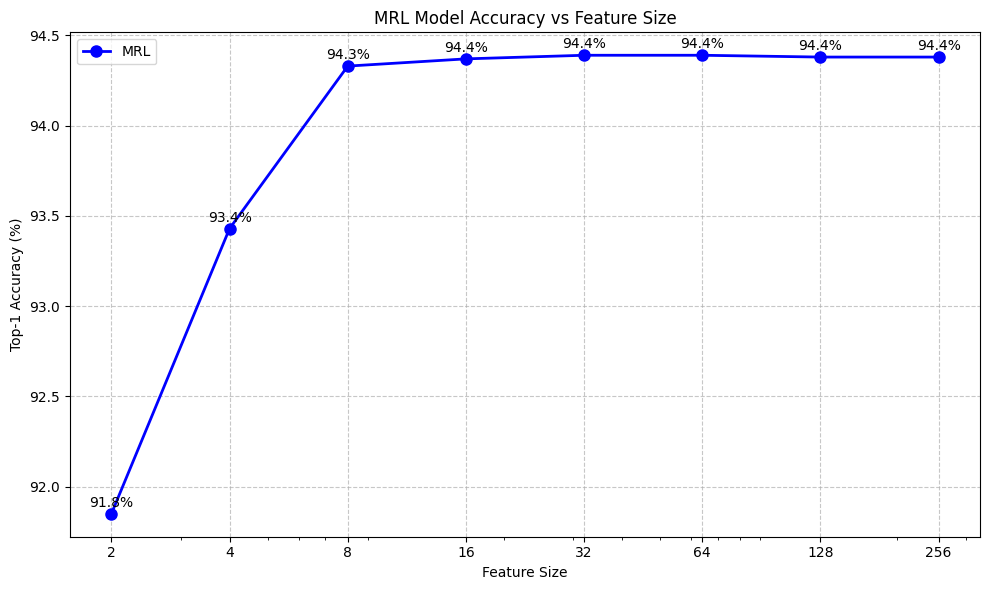

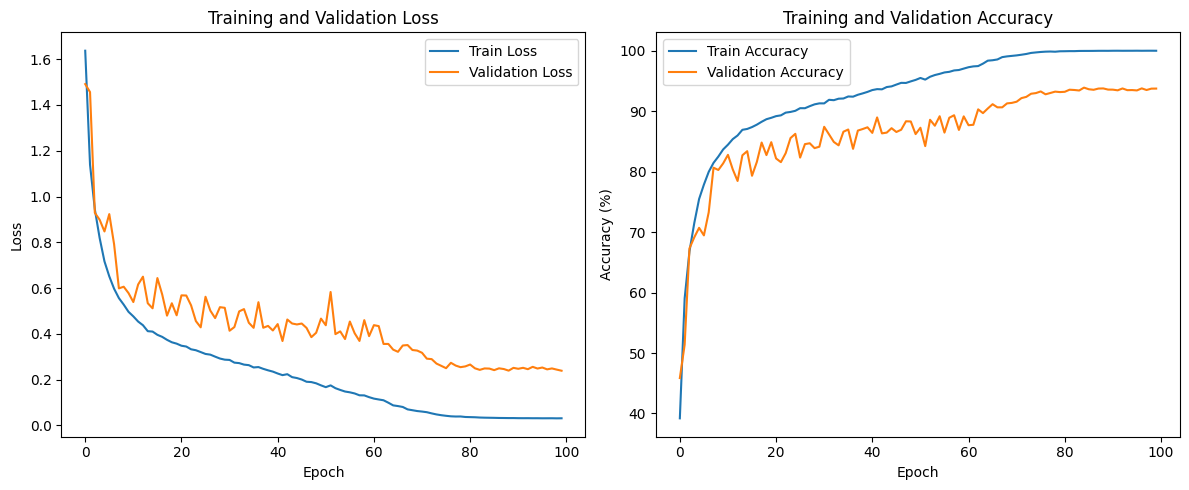

In [23]:
print("\nMRL Model Test Results:")
mrl_avg_top1, mrl_correct_top1 = test(model, test_loader, device, nesting_list=config['nesting_list'])

plot_mrl_accuracy(mrl_correct_top1, test_loader, config)
plot_training_curves(train_losses, val_losses, train_accs, val_accs)


In [24]:
print(f"\n{'='*50}")
print("Pre-computing embeddings for classifier training")
print(f"{'='*50}")

model.to(device)
model.eval()

train_features, train_labels = extract_features(train_loader, model, device)
val_features, val_labels = extract_features(val_loader, model, device)
test_features, test_labels = extract_features(test_loader, model, device)

print(f"Train features shape: {train_features.shape}, Train labels shape: {train_labels.shape}")
print(f"Val features shape: {val_features.shape}, Val labels shape: {val_labels.shape}")
print(f"Test features shape: {test_features.shape}, Test labels shape: {test_labels.shape}")

embedding_batch_size = 512

train_embedding_dataset = TensorDataset(train_features, train_labels)
train_embedding_loader = DataLoader(train_embedding_dataset, batch_size=embedding_batch_size, shuffle=True, num_workers=1) 

val_embedding_dataset = TensorDataset(val_features, val_labels)
val_embedding_loader = DataLoader(val_embedding_dataset, batch_size=embedding_batch_size, shuffle=False, num_workers=1)

test_embedding_dataset = TensorDataset(test_features, test_labels)
test_embedding_loader = DataLoader(test_embedding_dataset, batch_size=embedding_batch_size, shuffle=False, num_workers=1)

print("\nFinished pre-computing embeddings.")
print(f"{'='*50}")



Pre-computing embeddings for classifier training
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.92it/s]
Train features shape: torch.Size([45000, 256]), Train labels shape: torch.Size([45000])
Val features shape: torch.Size([5000, 256]), Val labels shape: torch.Size([5000])
Test features shape: torch.Size([10000, 256]), Test labels shape: torch.Size([10000])

Finished pre-computing embeddings.


In [25]:
print("Starting training fixed feature classifiers on pre-computed embeddings")
print(f"{'='*50}")

# model.eval()
# for param in model.parameters():
#     param.requires_grad = False

classifiers = {}
optimizers = {}
schedulers = {}

for size in config['nesting_list']:
    classifiers[size] = FixedFeatureClassifier(size, 10).to(device)
    optimizers[size] = optim.SGD(classifiers[size].parameters(), lr=0.05, momentum=0.9, weight_decay=1e-3)
    schedulers[size] = CosineAnnealingLR(optimizers[size], T_max=config['classifier_epochs'])

best_val_acc = 0
best_classifiers = None

train_loss_history = {size: [] for size in config['nesting_list']}
train_acc_history = {size: [] for size in config['nesting_list']}
val_acc_history = {size: [] for size in config['nesting_list']}

with tqdm(range(config['classifier_epochs']), desc='Training classifiers', file=sys.stdout, colour='green', ncols=120) as pbar:
    for epoch in pbar:
        train_stats = train_classifiers(classifiers, optimizers, train_embedding_loader, device, config['nesting_list'], epoch)
        val_stats = validate_classifiers(classifiers, val_embedding_loader, device, config['nesting_list'])

        for size in config['nesting_list']:
             if size in schedulers:
                 schedulers[size].step()
        
        avg_train_acc = sum(stats['acc'] for stats in train_stats.values()) / len(config['nesting_list'])
        avg_val_acc = sum(stats['acc'] for stats in val_stats.values()) / len(config['nesting_list'])

        pbar.set_postfix({
            'Train Acc': f'{avg_train_acc:.2f}%',
            'Val Acc': f'{avg_val_acc:.2f}%'
        })
        
        for size in config['nesting_list']:
            train_loss_history[size].append(train_stats[size]['loss'])
            train_acc_history[size].append(train_stats[size]['acc'])
            val_acc_history[size].append(val_stats[size]['acc'])

        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            best_classifiers = {size: classifiers[size] for size in config['nesting_list']} 

torch.save({
    'model': model.state_dict(),
    'classifiers': best_classifiers,
    'optimizer': optimizer.state_dict(),
}, 'mrl_resnet9_cifar10.pth')

Starting training fixed feature classifiers on pre-computed embeddings
Training classifiers: 100%|█████████████████████████| 100/100 [04:11<00:00,  2.52s/it, Train Acc=99.99%, Val Acc=93.60%]



Testing best fixed feature classifiers

Fixed Feature Classifiers Test Results (on pre-computed embeddings):

┌──────────┬────────────┐
│   Size   │ Top-1 Acc  │
├──────────┼────────────┤
│    2     │     92.00% │
│    4     │     93.34% │
│    8     │     94.23% │
│    16    │     94.26% │
│    32    │     94.26% │
│    64    │     94.26% │
│   128    │     94.26% │
│   256    │     94.26% │
└──────────┴────────────┘


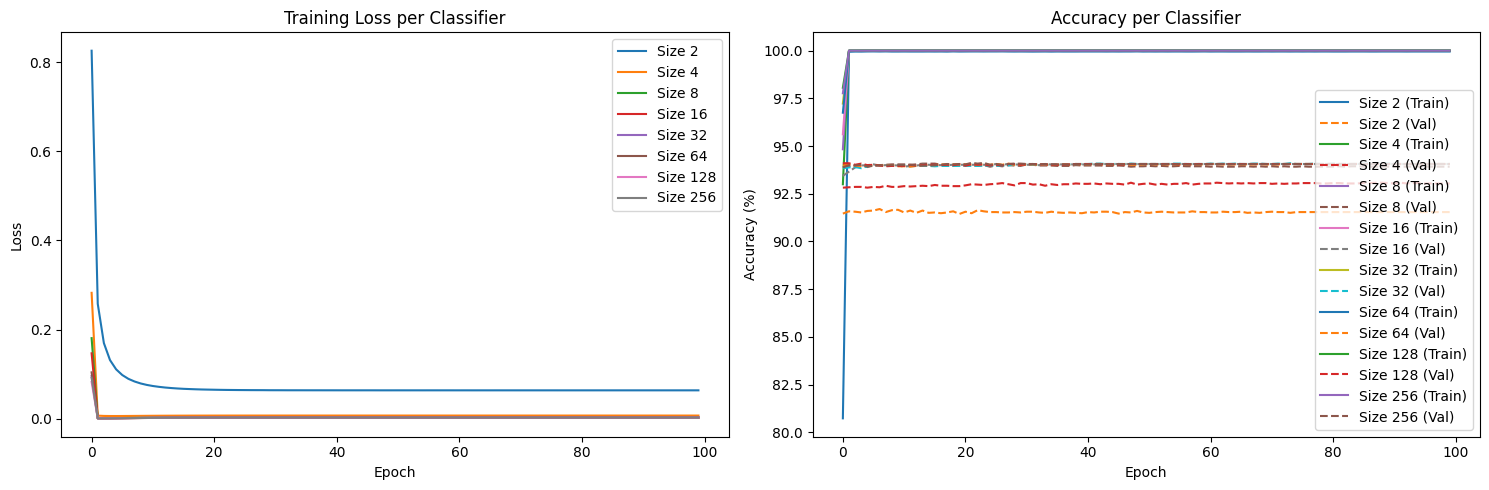

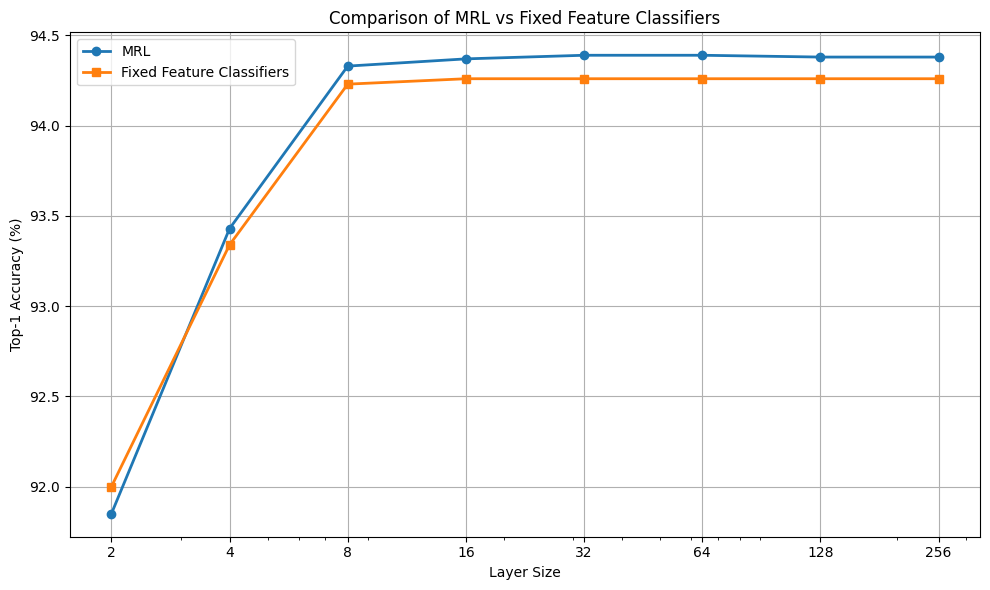

In [26]:
print("\nTesting best fixed feature classifiers")
test_stats = test_classifiers(best_classifiers, test_embedding_loader, device, config['nesting_list'])

plot_classifier_training(config['nesting_list'], train_loss_history, train_acc_history, val_acc_history)
plot_comparison(mrl_correct_top1, test_stats, test_loader, config)


Comparison Table:
┌──────────┬──────────────────────────┬──────────────────────────────┐
│   Size   │   Standalone ResNet-9    │    Classifier on MRL emb     │
├──────────┼──────────────────────────┼──────────────────────────────┤
│    2     │                   92.35% │                       92.00% │
│    4     │                   93.40% │                       93.34% │
│    8     │                   94.26% │                       94.23% │
│    16    │                   94.47% │                       94.26% │
│    32    │                   94.08% │                       94.26% │
│    64    │                   94.29% │                       94.26% │
│   128    │                   94.11% │                       94.26% │
│   256    │                   94.23% │                       94.26% │
└──────────┴──────────────────────────┴──────────────────────────────┘

Average Standalone ResNet-9: 93.90%
Average Classifiers on MRL embeddings: 93.86%


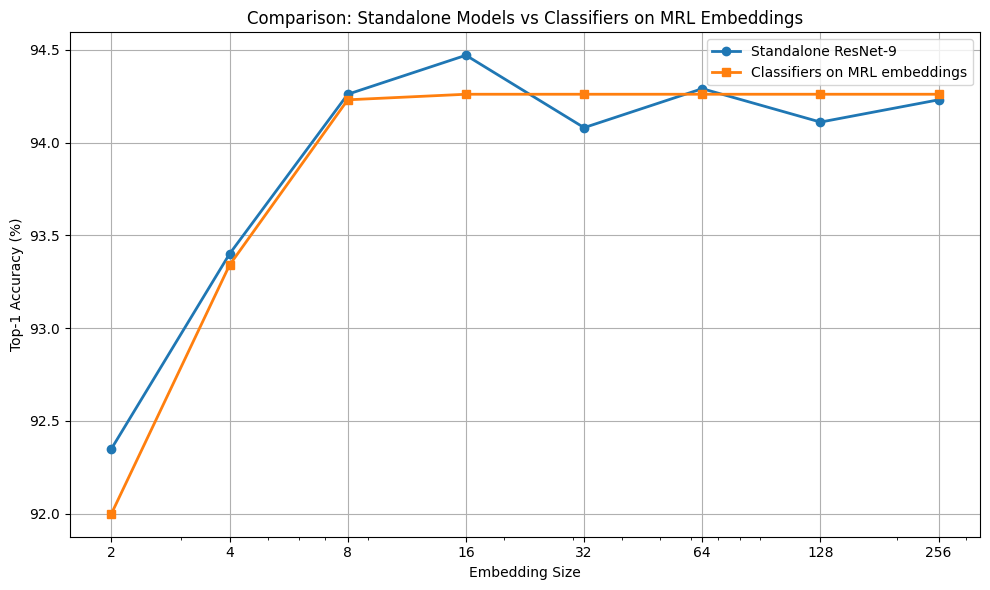

In [27]:
print("\nComparison Table:")
print("┌──────────┬──────────────────────────┬──────────────────────────────┐")
print(f"│ {'Size':^8} │ {'Standalone ResNet-9':^24} │ {'Classifier on MRL emb':^28} │")
print("├──────────┼──────────────────────────┼──────────────────────────────┤")

for size in sorted(config['nesting_list']):
    standalone_acc = fixed_results[size]
    mrl_classifier_acc = 100. * test_stats[size]['correct_top1'] / test_stats[size]['total']
    
    print(f"│ {size:^8} │ {standalone_acc:>23.2f}% │ {mrl_classifier_acc:>27.2f}% │")

print("└──────────┴──────────────────────────┴──────────────────────────────┘")

avg_standalone = sum(fixed_results.values()) / len(fixed_results)
avg_mrl_classifier = sum(100. * test_stats[size]['correct_top1'] / test_stats[size]['total'] 
                        for size in config['nesting_list']) / len(config['nesting_list'])

print(f"\nAverage Standalone ResNet-9: {avg_standalone:.2f}%")
print(f"Average Classifiers on MRL embeddings: {avg_mrl_classifier:.2f}%")

plot_final_comparison(fixed_results, test_stats, config)